**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/linear-regression-with-time-series).**

---


# Introduction #

Run this cell to set everything up!

In [3]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path('./data')
comp_dir = Path('./data/store-sales-time-series-forecasting')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

# generated from 0.95 * lag_1 + error for column one, and -0.95 * lag_1 + error for column two
ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [4]:
book_sales.head()

,Hardcover,Time,Lag_1
Date,,,
2000-04-01,139,0,NaN
2000-04-02,128,1,139.0
2000-04-03,172,2,128.0
2000-04-04,139,3,172.0
2000-04-05,191,4,139.0


In [5]:
ar.head()

,ar1,ar2
0,0.541286,-1.234475
1,-1.692950,3.532498
2,-1.730106,-3.915508
3,-0.783524,2.820841
4,-1.796207,-1.084120


In [6]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [7]:
# across all stores and sales categories (family) for date
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

--------------------------------------------------------------------------------

One advantage linear regression has over more complicated algorithms is that the models it creates are *explainable* -- it's easy to interpret what contribution each feature makes to the predictions. In the model `target = weight * feature + bias`, the `weight` tells you by how much the `target` changes on average for each unit of change in the `feature`.

Run the next cell to see a linear regression on *Hardcover Sales*.

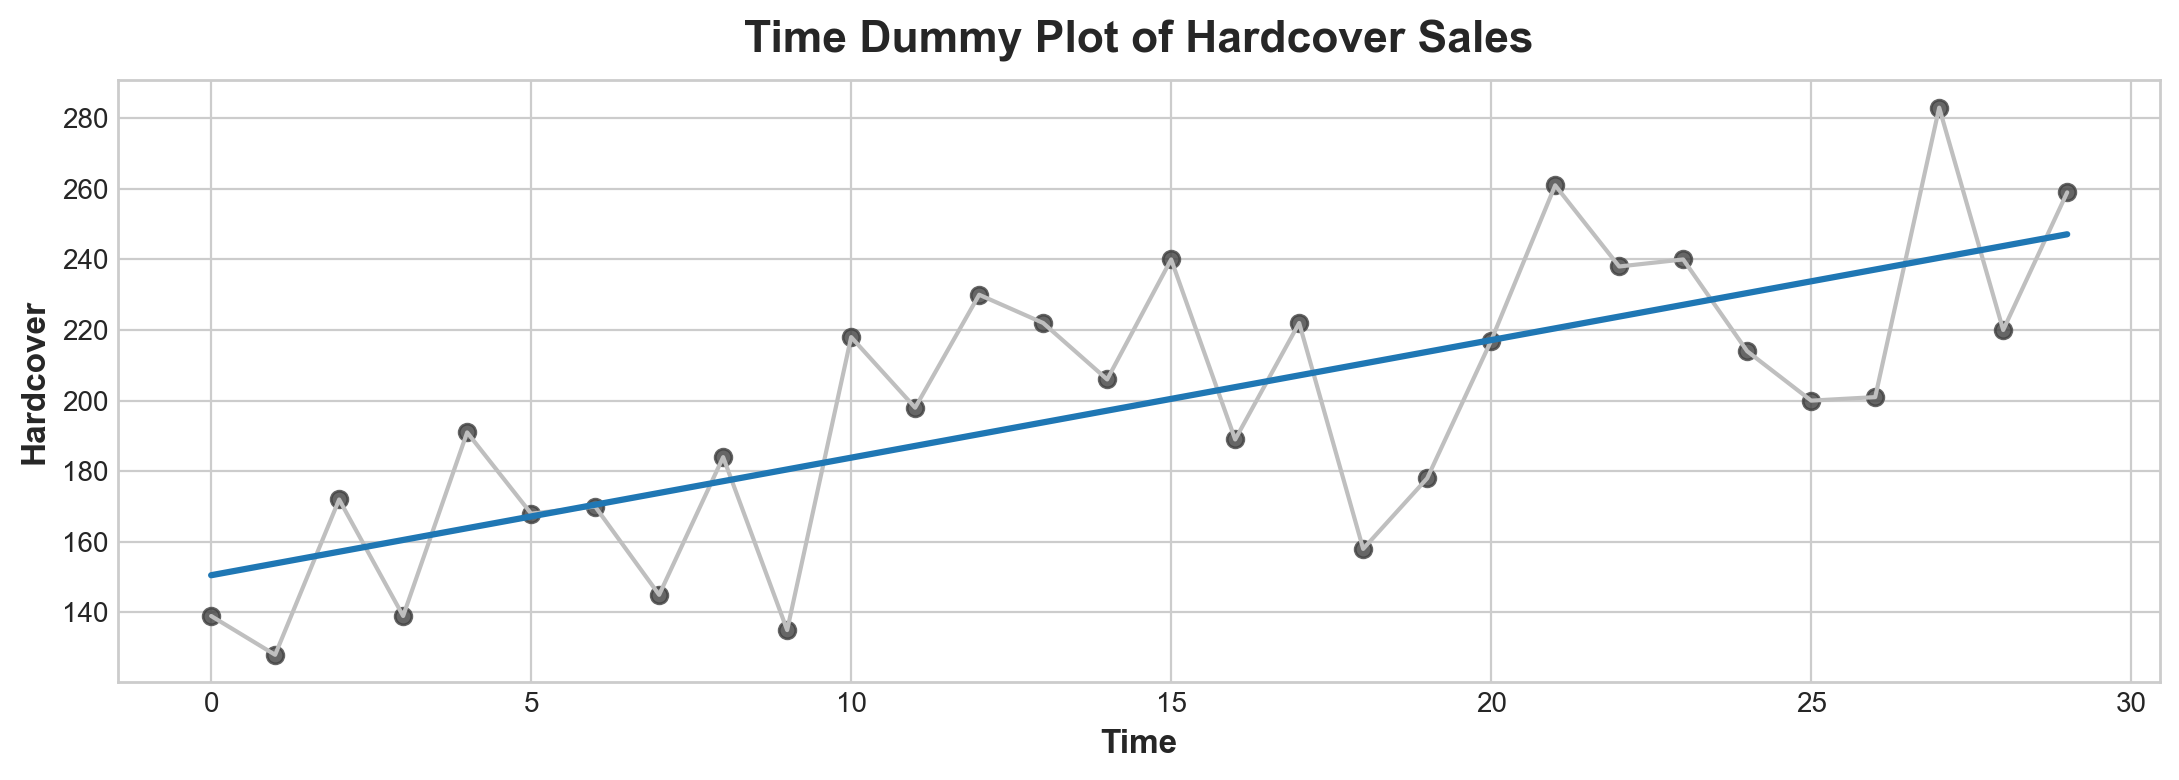

In [8]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Dummy Plot of Hardcover Sales');

# 1) Interpret linear regression with the time dummy

The linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. Over 6 days how much on average would you expect hardcover sales to change? After you've thought about it, run the next cell.

This should be 3.33 * 6 = 19.98

-------------------------------------------------------------------------------

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells you how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.

# 2) Interpret linear regression with a lag feature

Run the following cell to see two series generated according to the model just described.

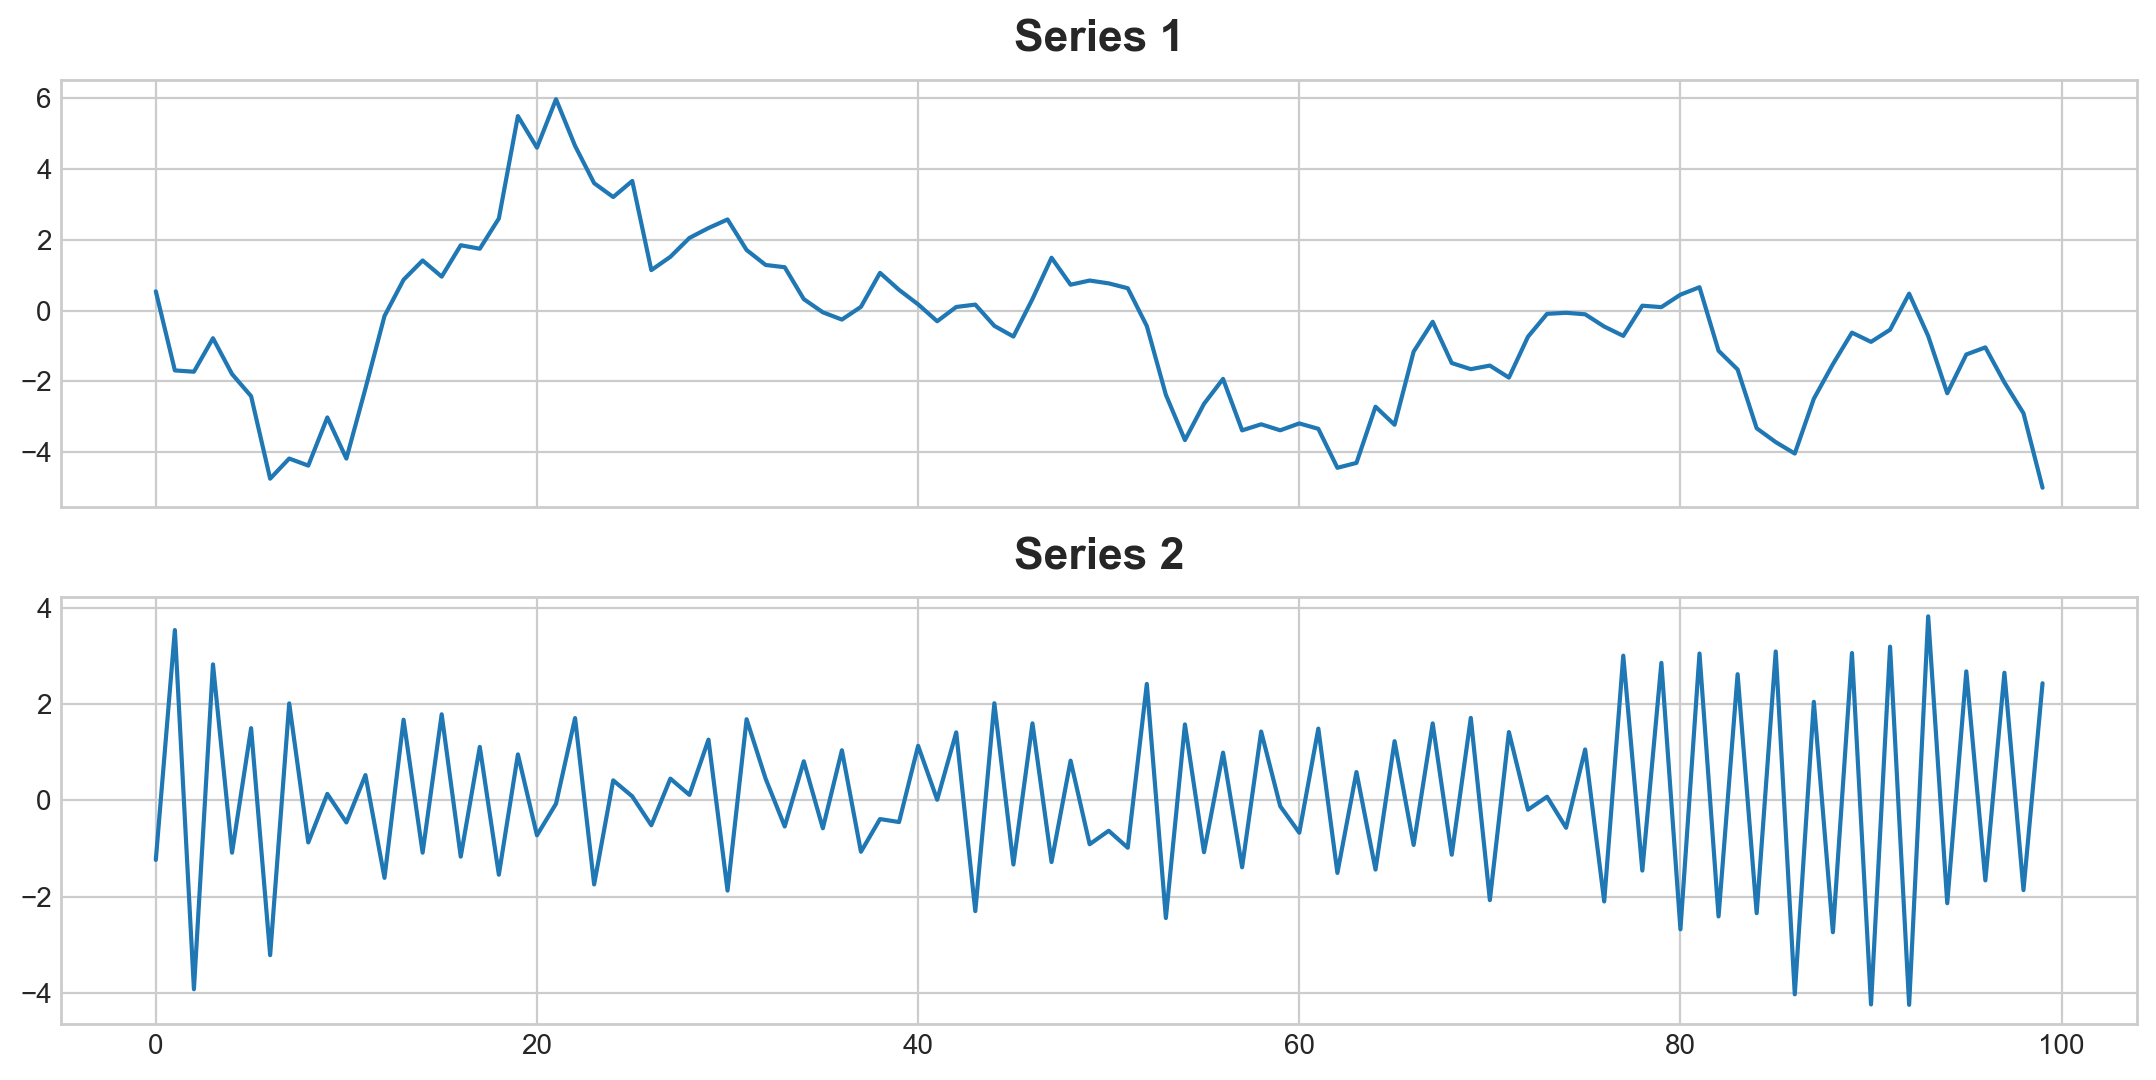

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, differing only by the sign on the lag feature. Can you tell which equation goes with each series?

```target = 0.95 * lag_1 + error``` goes with Series 1, since it displays serial dependence with the previous day (values that are positive for one day tend to be positive for next). Series two displays a pattern where the current day tends to be opposite in sign for the previous day,  

-------------------------------------------------------------------------------

Now we'll get started with the *Store Sales - Time Series Forecasting* competition data. The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (`average_sales`) of the average sales each day.

# 3) Fit a time-step feature

Complete the code below to create a linear regression model with a time-step feature on the series of average product sales. The target is in a column called `'sales'`.

In [17]:
df = average_sales.to_frame()
df.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390808
2013-01-03,202.840195
2013-01-04,198.911148
2013-01-05,267.873230


In [18]:
from sklearn.linear_model import LinearRegression

# Create a time dummy
time = np.arange(len(df.index))
df['time'] = time 

# Create training data
X = df.loc[:,['time']]  # features
y = df.loc[:,'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Run this cell if you'd like to see a plot of the result.

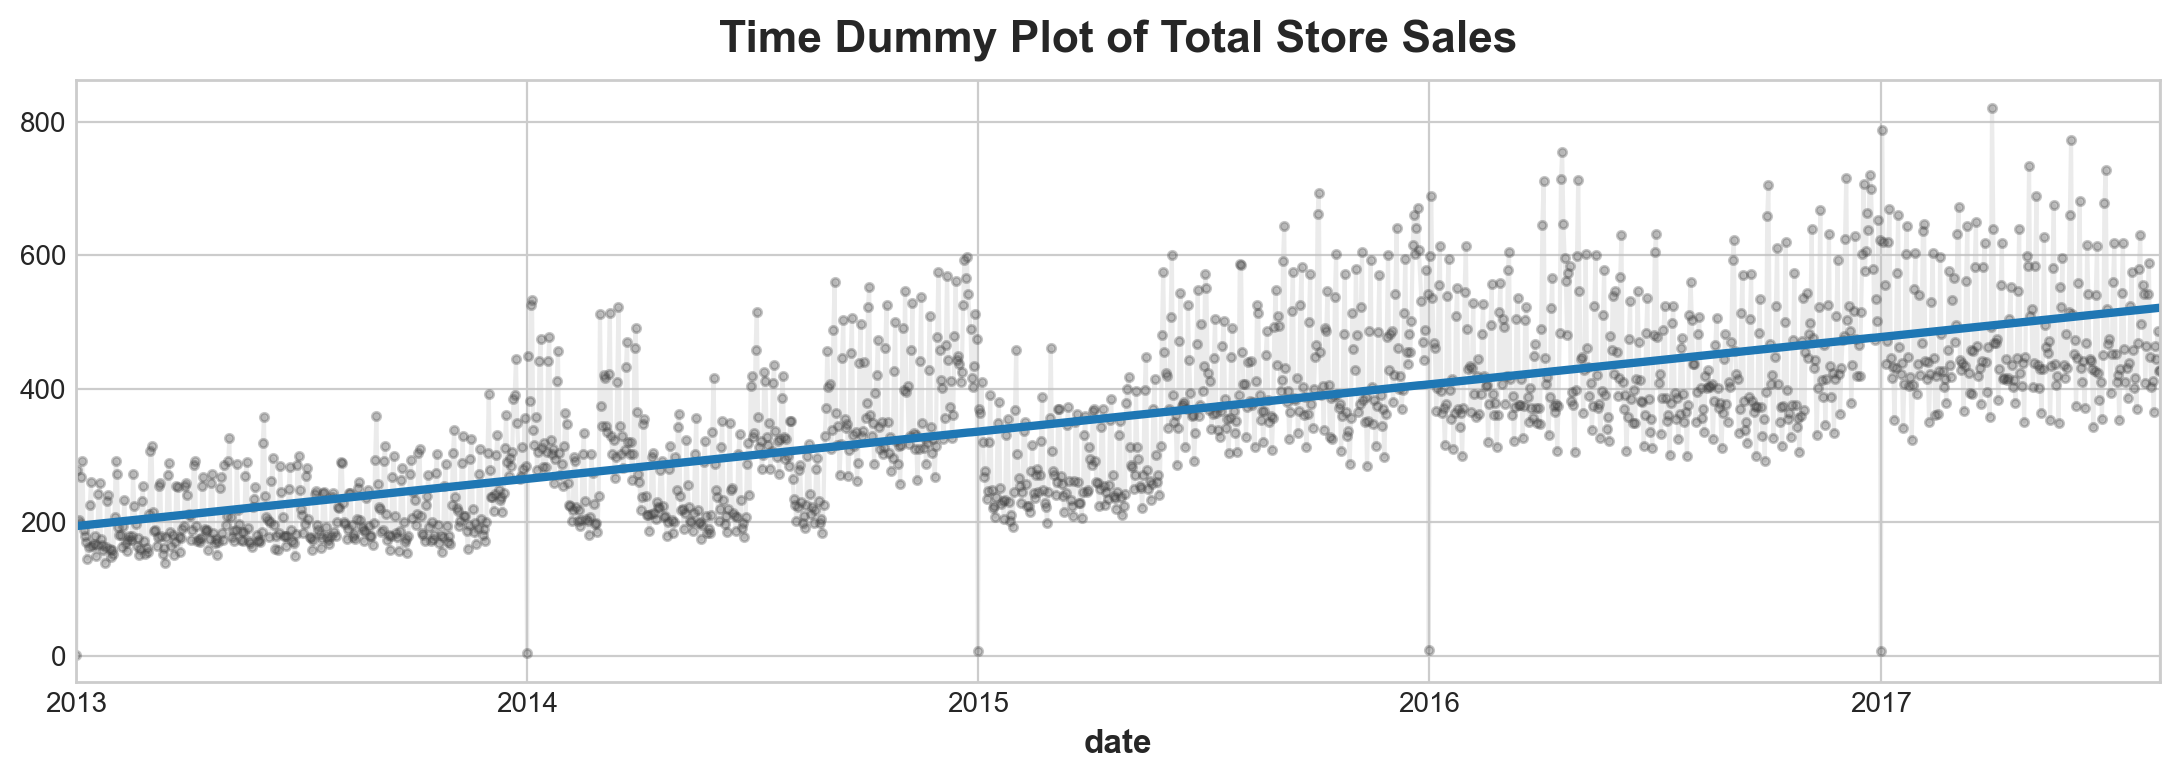

In [19]:
ax = y.plot(**plot_params, alpha=0.3)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Dummy Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Fit a lag feature to Store Sales

Complete the code below to create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [28]:
df = average_sales.to_frame()

# Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Run the next cell if you'd like to see the result.

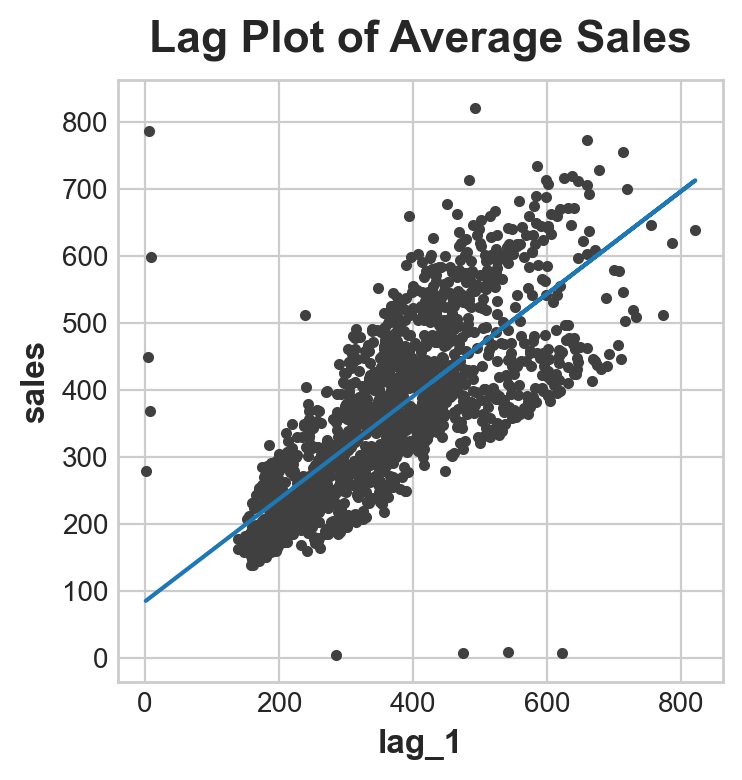

In [29]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

Or, viewed as a line plot overlay:

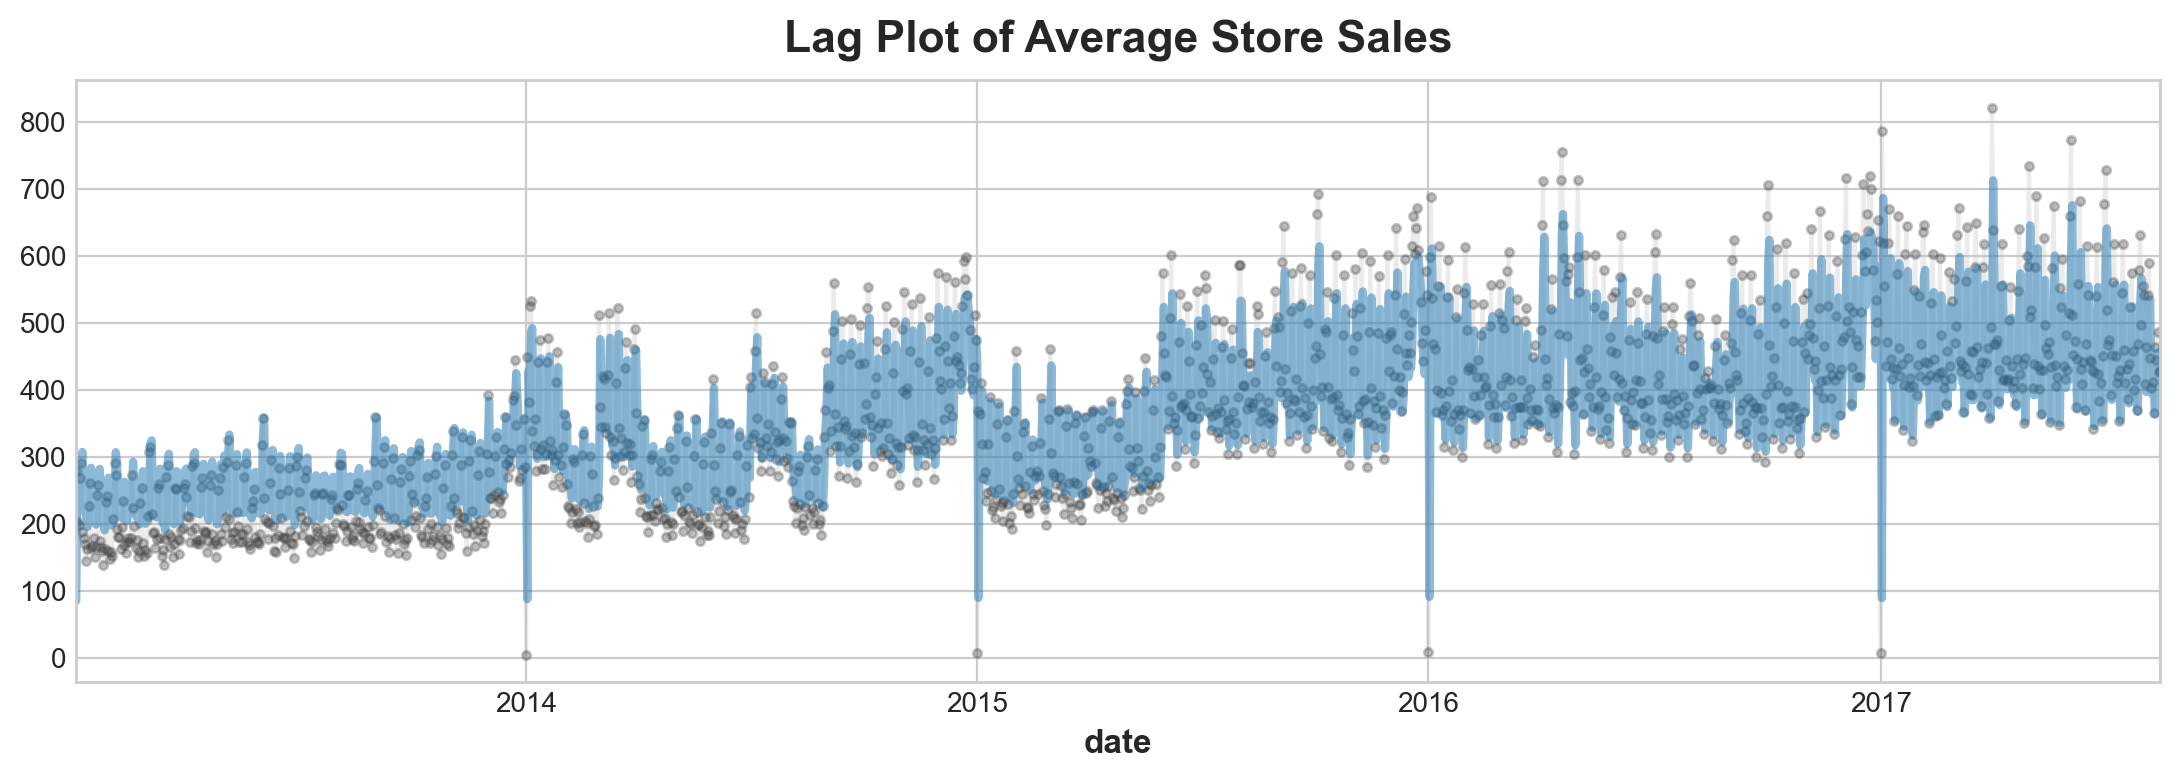

In [30]:
ax = y.plot(**plot_params, alpha=0.3)
ax = y_pred.plot(ax=ax, linewidth=3, alpha=0.5)
ax.set_title('Lag Plot of Average Store Sales');

# Keep Going #

[**Model trend**](https://www.kaggle.com/ryanholbrook/trend) in time series with moving average plots and the time dummy.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*